# Testing band-gap analysis

In [2]:
from pymatgen.io.vasp import Vasprun, Waveder
import numpy as np

# Load vasprun.xml
vasprun_file = "GaAs/hse/optics/vasprun.xml"
vasprun = Vasprun(vasprun_file)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0.25

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")



Lowest dipole-allowed direct transition: 1.463 eV


/home/matthew/miniforge3/envs/alignn-env/lib/python3.10/site-packages/pymatgen/io/vasp/outputs.py:993: UserWarning: No POTCAR file with matching TITEL fields was found in /home/matthew/PV_paper/vasp_stuff/GaAs/hse/optics
  warnings.warn(f"No POTCAR file with matching TITEL fields was found in {os.path.abspath(p)}")


In [3]:
import matplotlib.pyplot as plt

In [4]:
thresholds = np.linspace(0,1,100)
E_das = []
for threshold in thresholds:
    valid_indices = np.where(eps_imag_avg > threshold)[0]
    if valid_indices.size > 0:
        E_das.append(energies[valid_indices[0]])  # First dipole-allowed transition

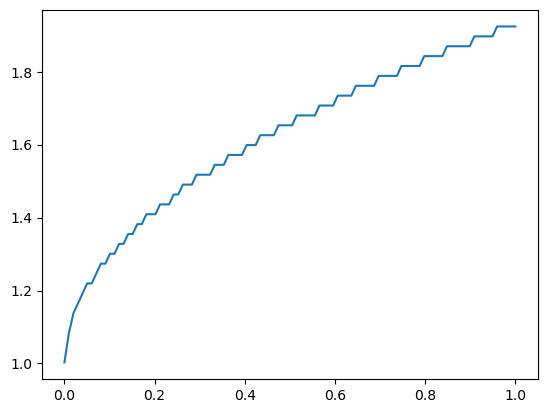

In [5]:
plt.plot(thresholds,E_das)

(0.0, 5.0)

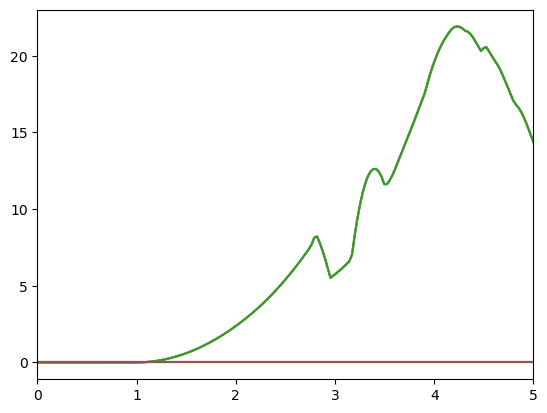

In [6]:
plt.plot(energies,eps_imag)
plt.xlim(0,5)

In [7]:
from jarvis.db.jsonutils import loadjson

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.io.vasp.outputs import Waveder, Vasprun
from typing import Dict, Any

def analyse_waveder(waveder_path: str, vasprun_path: str, threshold: float = 0) -> Dict[str, Any]:
    """
    analyse WAVEDER file to find lowest energy optical transition
    
    Parameters:
    -----------
    waveder_path : str
        Path to the WAVEDER file
    vasprun_path : str
        Path to the corresponding vasprun.xml file
    
    Returns:
    --------
    Dict containing details of the lowest energy optical transition
    """
    # Load WAVEDER file
    waveder = Waveder.from_binary(waveder_path)
    
    # Load Vasprun for additional context
    vasprun = Vasprun(vasprun_path, parse_potcar_file=False)
    
    # Extract band structure
    bs = vasprun.get_band_structure()
    
    # Get Fermi energy
    fermi_energy = vasprun.efermi
    
    # Prepare to track lowest energy transition
    lowest_energy_transition = {
        'energy_diff': float('inf'),
        'matrix_element_magnitude': 0,
        'k_point_index': None,
        'valence_band': None,
        'conduction_band': None,
        'k_point_coords': None
    }
    
    # Extract waveder data
    cder_real = waveder.as_dict()['cder_real']
    cder_imag = waveder.as_dict()['cder_imag']
    
    # Iterate through k-points
    for k_index in range(cder_real.shape[2]):
        # Iterate through valence bands
        for v_band in range(cder_real.shape[0]):
            # Get valence band energy
            bs_keys = list(bs.bands.keys())
            valence_energy = bs.bands[bs_keys[0]][v_band, k_index]
            
            # Skip if valence band is above Fermi energy
            if valence_energy > fermi_energy:
                continue
            
            # Iterate through conduction bands
            for c_band in range(cder_real.shape[1]):
                # Get conduction band energy
                conduction_energy = bs.bands[bs_keys[0]][c_band,k_index]
                
                # Skip if conduction band is below Fermi energy
                if conduction_energy < fermi_energy:
                    continue
                
                # Extract matrix elements (combine real and imaginary parts)
                matrix_elements_real = cder_real[v_band, c_band, k_index, 0, :]
                matrix_elements_imag = cder_imag[v_band, c_band, k_index, 0, :]
                matrix_elements = matrix_elements_real + 1j * matrix_elements_imag
                
                # Calculate matrix element magnitude
                matrix_element_magnitude = np.linalg.norm(matrix_elements)
                
                # Skip if matrix element is essentially zero
                if matrix_element_magnitude < 1e-10:
                    continue
                
                # Calculate energy difference
                energy_diff = conduction_energy - valence_energy
                
                # Update lowest energy transition if applicable
                if energy_diff > 0 and energy_diff < lowest_energy_transition['energy_diff'] and matrix_element_magnitude > threshold:
                    lowest_energy_transition = {
                        'energy_diff': energy_diff,
                        'matrix_element_magnitude': matrix_element_magnitude,
                        'k_point_index': k_index,
                        'valence_band': v_band,
                        'conduction_band': c_band,
                        'k_point_coords': bs.kpoints[k_index].frac_coords,
                        'matrix_elements_real': matrix_elements_real,
                        'matrix_elements_imag': matrix_elements_imag,
                        'matrix_elements_complex': matrix_elements,
                        'valence_energy': valence_energy,
                        'conduction_energy': conduction_energy
                    }
    optics_gap = bs.get_band_gap()
    optics_dir_gap = bs.get_direct_band_gap()
    static_bs = Vasprun(waveder_path[:-14]+"static/vasprun.xml",parse_potcar_file=False).get_band_structure()
    static_gap = static_bs.get_band_gap()
    dir_gap = static_bs.get_direct_band_gap()
    return lowest_energy_transition, optics_gap, optics_dir_gap, static_gap, dir_gap

def visualize_matrix_elements(transition: Dict[str, Any]):
    """
    Visualize matrix elements for the lowest energy transition
    
    Parameters:
    -----------
    transition : Dict
        Details of the lowest energy optical transition
    """
    plt.figure(figsize=(12, 6))
    
    # Real matrix elements
    plt.subplot(1, 2, 1)
    plt.bar(range(len(transition['matrix_elements_real'])), 
            np.abs(transition['matrix_elements_real']))
    plt.title('Real Matrix Element Magnitudes')
    plt.xlabel('Component')
    plt.ylabel('Magnitude')
    
    # Imaginary matrix elements
    plt.subplot(1, 2, 2)
    plt.bar(range(len(transition['matrix_elements_imag'])), 
            np.abs(transition['matrix_elements_imag']))
    plt.title('Imaginary Matrix Element Magnitudes')
    plt.xlabel('Component')
    plt.ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

def main(waveder_path: str, vasprun_path: str,threshold: float = 0, plot: bool = False):
    """
    Main analysis function
    
    Parameters:
    -----------
    waveder_path : str
        Path to the WAVEDER file
    vasprun_path : str
        Path to the corresponding vasprun.xml file
    """
    # analyse WAVEDER file
    lowest_transition,optics_gap,optics_dir_gap, static_gap,dir_gap = analyse_waveder(waveder_path, vasprun_path,threshold=threshold)
    
    # Print detailed results
    print("Lowest Energy Optical Transition:")
    print(f"Energy Difference: {lowest_transition['energy_diff']:.4f} eV")
    print(f"Valence Band Energy: {lowest_transition['valence_energy']:.4f} eV")
    print(f"Conduction Band Energy: {lowest_transition['conduction_energy']:.4f} eV")
    print(f"Matrix Element Magnitude: {lowest_transition['matrix_element_magnitude']:.4e}")
    print(f"K-point Index: {lowest_transition['k_point_index']}")
    print(f"K-point Coordinates: {lowest_transition['k_point_coords']}")
    print(f"Valence Band: {lowest_transition['valence_band']}")
    print(f"Conduction Band: {lowest_transition['conduction_band']}")
    print(f"Direct gap? {optics_gap['direct']}")
    print(f"Band-gap from optics: {optics_gap['energy']} eV")
    print(f"Direct gap from optics: {optics_dir_gap} eV")
    print(f"Band-gap from static: {static_gap['energy']} eV")
    print(f"Direct gap from static: {dir_gap} eV")
    
    # Visualize matrix elements
    if plot:
        visualize_matrix_elements(lowest_transition)
    
    return lowest_transition

In [9]:
waveder_path = "GaAs/hse/optics/WAVEDER"
vasprun_path = "GaAs/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path)

Lowest Energy Optical Transition:
Energy Difference: 0.9896 eV
Valence Band Energy: 3.0437 eV
Conduction Band Energy: 4.0333 eV
Matrix Element Magnitude: 9.0305e+00
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 33
Conduction Band: 36
Direct gap? True
Band-gap from optics: 0.9895999999999998 eV
Direct gap from optics: 0.9895999999999998 eV
Band-gap from static: 1.3794999999999997 eV
Direct gap from static: 1.3794999999999997 eV


In [10]:
FT_master = loadjson('/home/matthew/mpcontribs-downloads/FT_master.json')

In [11]:
mpid_kim = loadjson('/home/matthew/hybrid_gaps/MPID_Kim_data.json')

In [12]:
FT_master['mp-1000']

{'gap': 1.593, 'delta': 0.0, 'edge_delta': 1.974, 'OT_type': 'ia'}

In [13]:
FT_types = {k:v['OT_type'] for k,v in FT_master.items()}

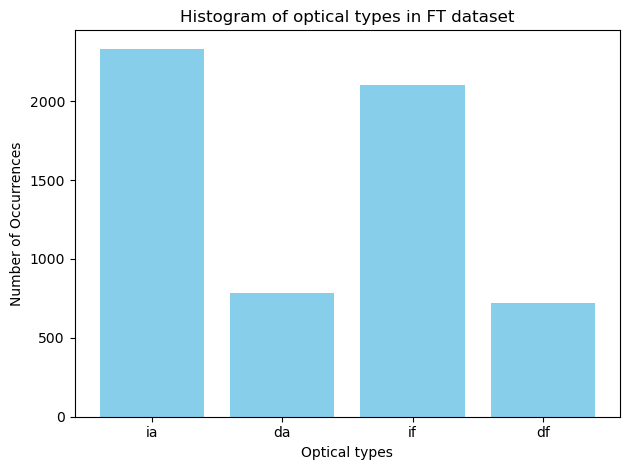

In [14]:
# Count occurrences of each value
value_counts = {}
for key,value in FT_types.items():
    if key in mpid_kim:
        value_counts[value] = value_counts.get(value, 0) + 1

# Prepare data for the histogram
values = list(value_counts.keys())
counts = list(value_counts.values())

# Create the histogram
plt.bar(values, counts, color='skyblue')
plt.xlabel('Optical types')
plt.ylabel('Number of Occurrences')
plt.title('Histogram of optical types in FT dataset')
#plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
kim_forbidden = {k:v for k,v in mpid_kim.items() if k in FT_types and (FT_types[k] == "if" or FT_types[k] == "df")}

In [16]:
key_materials = loadjson('/home/matthew/key_materials/key_materials.json')

In [17]:
key_mpids = list(key_materials.values())

In [18]:
for i in key_mpids:
    if i in kim_forbidden:
        print(i)

mp-22811
mp-361
mp-149


In [19]:
FT_types['mp-149']

'if'

In [20]:
kim_forbidden['mp-149']

{'atoms': {'lattice_mat': [[0.0, 2.7329598041993197, 2.7329598041993197],
   [2.7329598041993197, 0.0, 2.7329598041993197],
   [2.7329598041993197, 2.7329598041993197, 0.0]],
  'coords': [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]],
  'elements': ['Si', 'Si'],
  'abc': [3.864989, 3.864989, 3.864989],
  'angles': [60.0, 60.0, 60.0],
  'cartesian': False,
  'props': ['', '']},
 'icsds': ['51688'],
 'GGA_gap': 0.612995,
 'HSE_gap': 1.188769,
 'GGA_opt': 2.562729,
 'HSE_opt': 3.327221,
 'Correction': 0.575774,
 'GGA_offset': 1.949734,
 'HSE_offset': 2.138452}

In [21]:
if __name__ == "__main__":
    waveder_path = "Si/hse/optics/WAVEDER"
    vasprun_path = "Si/hse/optics/vasprun.xml"
    optical_transition = main(waveder_path, vasprun_path)

Lowest Energy Optical Transition:
Energy Difference: 3.3415 eV
Valence Band Energy: 5.3871 eV
Conduction Band Energy: 8.7286 eV
Matrix Element Magnitude: 1.4674e+00
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 1
Conduction Band: 4
Direct gap? False
Band-gap from optics: 1.1695000000000002 eV
Direct gap from optics: 3.3415 eV
Band-gap from static: 1.1666999999999996 eV
Direct gap from static: 3.3373999999999997 eV


In [22]:
FT_types['mp-22811']

'df'

In [23]:
kim_forbidden['mp-22811']

{'atoms': {'lattice_mat': [[-2.951166400327474,
    2.951166400327474,
    5.869269683690702],
   [2.951166400327474, -2.951166400327474, 5.869269683690702],
   [2.951166400327474, 2.951166400327474, -5.869269683690702]],
  'coords': [[0.75, 0.25, 0.5],
   [-0.0, -0.0, -0.0],
   [0.25, 0.75, 0.5],
   [0.5, 0.5, -0.0],
   [0.6538749184259411, 0.125, 0.028874918425941],
   [0.096125081574059, 0.625, 0.9711250815740589],
   [0.375, 0.346125081574059, 0.471125081574059],
   [0.875, 0.9038749184259411, 0.5288749184259411]],
  'elements': ['Cu', 'Cu', 'In', 'In', 'Se', 'Se', 'Se', 'Se'],
  'abc': [7.201884, 7.201884, 7.201884],
  'angles': [131.6183, 131.6183, 70.8326],
  'cartesian': False,
  'props': ['', '', '', '', '', '', '', '']},
 'icsds': ['154405', '250247', '73351'],
 'GGA_gap': 0.036091,
 'HSE_gap': 0.6419719999999999,
 'GGA_opt': 0.7350423333333334,
 'HSE_opt': 0.6419719999999999,
 'Correction': 0.605881,
 'GGA_offset': 0.6989513333333334,
 'HSE_offset': 0.0}

In [24]:
waveder_path = "InCuSe2/hse/optics/WAVEDER"
vasprun_path = "InCuSe2/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path)

Lowest Energy Optical Transition:
Energy Difference: 0.7633 eV
Valence Band Energy: 3.5625 eV
Conduction Band Energy: 4.3258 eV
Matrix Element Magnitude: 7.7784e+00
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 35
Conduction Band: 36
Direct gap? True
Band-gap from optics: 0.7633000000000001 eV
Direct gap from optics: 0.7633000000000001 eV
Band-gap from static: 0.7629999999999999 eV
Direct gap from static: 0.7632999999999996 eV


In [25]:
FT_types['mp-361']

'df'

In [26]:
kim_forbidden['mp-361']

{'atoms': {'lattice_mat': [[4.294412618287842, -0.0, 0.0],
   [0.0, 4.294412618287842, -0.0],
   [0.0, -0.0, 4.294412618287842]],
  'coords': [[0.75, 0.25, 0.25],
   [0.25, 0.25, 0.75],
   [0.25, 0.75, 0.25],
   [0.75, 0.75, 0.75],
   [0.5, 0.5, 0.5],
   [-0.0, 0.0, -0.0]],
  'elements': ['Cu', 'Cu', 'Cu', 'Cu', 'O', 'O'],
  'abc': [4.29441, 4.29441, 4.29441],
  'angles': [90.0, 90.0, 90.0],
  'cartesian': False,
  'props': ['', '', '', '', '', '']},
 'icsds': ['167446', '190597'],
 'GGA_gap': 0.6422335,
 'HSE_gap': 1.9608075,
 'GGA_opt': 0.6422335,
 'HSE_opt': 1.9608075,
 'Correction': 1.318574,
 'GGA_offset': 0.0,
 'HSE_offset': 0.0}

In [27]:
waveder_path = "Cu2O/hse/optics/WAVEDER"
vasprun_path = "Cu2O/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path)

Lowest Energy Optical Transition:
Energy Difference: 2.0667 eV
Valence Band Energy: 3.8647 eV
Conduction Band Energy: 5.9314 eV
Matrix Element Magnitude: 4.3917e-08
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 25
Conduction Band: 28
Direct gap? True
Band-gap from optics: 2.0667 eV
Direct gap from optics: 2.0667 eV
Band-gap from static: 2.0653 eV
Direct gap from static: 2.0664000000000002 eV


In [28]:
mpid_kim['mp-2534']

{'atoms': {'lattice_mat': [[0.0, 2.8768807790576263, 2.8768807790576263],
   [2.8768807790576263, 0.0, 2.8768807790576263],
   [2.8768807790576263, 2.8768807790576263, 0.0]],
  'coords': [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]],
  'elements': ['Ga', 'As'],
  'abc': [4.068523, 4.068523, 4.068523],
  'angles': [60.0, 60.0, 60.0],
  'cartesian': False,
  'props': ['', '']},
 'icsds': ['41981', '610533'],
 'GGA_gap': 0.18221700000000002,
 'HSE_gap': 0.9537105,
 'GGA_opt': 0.18221700000000002,
 'HSE_opt': 0.9537105,
 'Correction': 0.7714935,
 'GGA_offset': 0.0,
 'HSE_offset': 0.0}

In [29]:
waveder_path = "GaAs/hse/optics/WAVEDER"
vasprun_path = "GaAs/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path)

Lowest Energy Optical Transition:
Energy Difference: 0.9896 eV
Valence Band Energy: 3.0437 eV
Conduction Band Energy: 4.0333 eV
Matrix Element Magnitude: 9.0305e+00
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 33
Conduction Band: 36
Direct gap? True
Band-gap from optics: 0.9895999999999998 eV
Direct gap from optics: 0.9895999999999998 eV
Band-gap from static: 1.3794999999999997 eV
Direct gap from static: 1.3794999999999997 eV


In [30]:
sb2se3_vasprun = Vasprun("Sb2Se3/hse/optics/vasprun.xml",parse_potcar_file=False)

In [31]:
waveder = Waveder.from_binary("GaAs/hse/optics/WAVEDER")
waveder.as_dict().keys()

dict_keys(['@module', '@class', '@version', 'cder_real', 'cder_imag'])

In [32]:
cder_real = waveder.as_dict()['cder_real']

In [33]:
cder_real.shape

(144, 72, 10, 1, 3)

In [34]:
sb2se3_bs = sb2se3_vasprun.get_band_structure()

In [35]:
bands_keys = list(sb2se3_bs.bands.keys())

In [36]:
sb2se3_bs.bands[bands_keys[0]].shape

(108, 16)

In [37]:
bands = sb2se3_bs

In [38]:
bands.kpoints[0].cart_coords

array([0., 0., 0.])

In [39]:
sb2se3_bs.get_direct_band_gap()

1.6125999999999996

In [40]:
sb2se3_bs.get_band_gap()

{'direct': False,
 'energy': 1.4537999999999998,
 'transition': '(0.000,0.000,0.500)-(0.000,0.500,0.000)'}

In [41]:
snum_master = loadjson('../../hybrid_gaps/clean_Kim_data.json')

In [42]:
import pandas as pd

In [43]:
best_data = pd.read_csv('../Yu_Zunger_best.csv')
icsd_to_mp = loadjson('../../hybrid_gaps/icsd_to_mp.json')


In [44]:
best_ids =[str(i) for i in best_data['ICSD']]

In [45]:
len(set(best_ids).intersection(set(snum_master.keys())))

4

In [46]:
snum_ids = list(snum_master.keys())

In [47]:
len(set(best_ids).intersection(set(icsd_to_mp.keys())))

19

In [48]:
dict_icsds = list(icsd_to_mp.keys())

In [49]:
mp_to_icsd = loadjson('../../hybrid_gaps/mp_to_icsd.json')

In [50]:
Si_icsds = mp_to_icsd["mp-149"]

In [51]:
def overlap(a,b):
    return set(a).intersection(set(b))

In [52]:
overlap(Si_icsds,snum_ids)

{'51688'}

In [53]:
snum_master['51688']

{'GGA_gap': 0.612995,
 'HSE_gap': 1.188769,
 'GGA_opt': 2.562729,
 'HSE_opt': 3.327221,
 'Correction': 0.575774,
 'GGA_offset': 1.949734,
 'HSE_offset': 2.138452,
 'atoms': {'lattice_mat': [[0.0, 2.7329598041993197, 2.7329598041993197],
   [2.7329598041993197, 0.0, 2.7329598041993197],
   [2.7329598041993197, 2.7329598041993197, 0.0]],
  'coords': [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]],
  'elements': ['Si', 'Si'],
  'abc': [3.864989, 3.864989, 3.864989],
  'angles': [60.0, 60.0, 60.0],
  'cartesian': False,
  'props': ['', '']}}

In [54]:
dict_icsds[0]

'410763'

In [55]:
best_ids[0]

'656271'

In [56]:
overlap(best_ids,snum_ids)

{'151871', '23290', '300181', '35597'}

In [57]:
snum_master['151871']

{'GGA_gap': 0.284829,
 'HSE_gap': 0.912684,
 'GGA_opt': 0.284829,
 'HSE_opt': 0.912684,
 'Correction': 0.627855,
 'GGA_offset': 0.0,
 'HSE_offset': 0.0,
 'atoms': {'lattice_mat': [[6.356417107447464, 0.0, 0.0],
   [0.0, 6.356417107447464, 0.0],
   [0.0, 0.0, 12.728592924486497]],
  'coords': [[0.0, -0.0, 0.5],
   [0.5, -0.0, 0.2553083314249917],
   [0.5, -0.0, 0.7446916685750082],
   [0.0, 0.5, 0.7446916685750082],
   [0.0, 0.5, 0.2553083314249917],
   [0.5, 0.5, 0.0],
   [0.7763728087309493, 0.7763728087309493, 0.1111558288747164],
   [0.2236271912690508, 0.2236271912690508, 0.1111558288747164],
   [0.2236271912690508, 0.7763728087309493, 0.8888441711252835],
   [0.7763728087309493, 0.2236271912690508, 0.8888441711252835],
   [0.2705608056475018, 0.2705608056475018, 0.611874640859819],
   [0.7294391943524983, 0.7294391943524983, 0.611874640859819],
   [0.7294391943524983, 0.2705608056475018, 0.388125359140181],
   [0.2705608056475018, 0.7294391943524983, 0.388125359140181]],
  'elemen

In [58]:
best_data["ICSD"] = best_data["ICSD"].astype(str)

In [59]:
best_data.loc[best_data['ICSD'].isin(overlap(best_ids,snum_ids))]

,Compound,ICSD,Space_group,E_g^i,E_g^df,E_g^da,E_g,Dielectric_constant,SLME
7,AgIn5Te8,151871,111,–,1.32,1.25,1,8.18,26.3
22,Cu3TlS2,23290,12,1.07,1.21,1.21,3,7.76,26.1
23,Cs3AlTe3,300181,14,1.52,1.75,1.59,3,4.58,24.3
24,AgIn5Se8,35597,111,1.48,2.35,1.52,3,6.11,22.2


In [60]:
useful = [[mat,snum_master[mat]["HSE_gap"],snum_master[mat]["HSE_opt"],snum_master[mat]["HSE_offset"]] for mat in overlap(best_ids,snum_ids)]

In [61]:
useful

[['35597', 1.0597299999999998, 2.440571, 1.380841],
 ['23290', 1.242963, 1.978478, 0.7355149999999999],
 ['151871', 0.912684, 0.912684, 0.0],
 ['300181', 2.921594, 3.477356, 0.5557620000000001]]

In [62]:
all_yu = pd.read_csv('../Yu_Zunger_gaps.csv')

In [63]:
all_yu["ICSD"]= all_yu["ICSD"].astype(str)

In [64]:
len(overlap(all_yu["ICSD"],snum_ids))

93

In [65]:
all_ids = list(all_yu["ICSD"])

In [66]:
len(all_ids)

256

In [67]:
all_useful = useful = [[mat,snum_master[mat]["HSE_gap"],snum_master[mat]["HSE_opt"],snum_master[mat]["HSE_offset"]] for mat in overlap(all_ids,snum_ids)]

In [68]:
all_yu.loc[all_yu['ICSD'].isin(overlap(all_ids,snum_ids))]

,Compound,ICSD,Space_group_no,E_g^i,E_g^df,E_g^da,Type,Dielectric_constant
18,Na3BO3,1351,14,6.16,6.28,6.51,4,2.04
27,NaGaO2,36652,33,–,6.22,5.92,1,2.45
28,NaInO2,34600,166,–,4.4,4.85,2,2.99
29,Na5InO4,69630,59,4.22,4.42,4.23,3,2.39
33,Na3TlO2,202028,62,3.22,3.73,3.67,3,3.58
...,...,...,...,...,...,...,...,...
229,Cs3AlTe3,300181,14,1.52,1.75,1.59,3,4.58
241,AgAlTe2,28746,122,–,2.51,2.58,2,6.21
247,AgIn5Te8,151871,111,–,1.32,1.25,1,8.18
250,AgTl3Te2,61680,14,0.75,1.06,1.16,4,13.17


In [101]:
yu_gaps_etc = {}
yu_fun_gaps = {}
for row in all_yu.iterrows():
    d = {}
    d['Type'] = row[1]['Type']
    try:
        d['E_g^da'] = float(row[1]['E_g^da'])
    except:
        print("Could not convert E_g^da to float:", row[1]['E_g^da'])
    if row[1]['Type'] == '1': 
        d['E_g'] = float(row[1]['E_g^da'])
        d['Offset'] = 0
        yu_fun_gaps[row[1]['ICSD']] = float(row[1]['E_g^da'])
    elif row[1]['Type'] == '2':
        d['E_g'] = float(row[1]['E_g^df'])
        d['Offset'] = float(row[1]['E_g^da']) - float(row[1]['E_g^df'])
        yu_fun_gaps[row[1]['ICSD']] = float(row[1]['E_g^df'])
    elif row[1]['Type'] == '3' or row[1]['Type'] == '4':
        d['E_g'] = float(row[1]['E_g^i'])
        d['Offset'] = float(row[1]['E_g^da']) - float(row[1]['E_g^i'])
        yu_fun_gaps[row[1]['ICSD']] = float(row[1]['E_g^i'])
    yu_gaps_etc[row[1]['ICSD']] = d


Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –
Could not convert E_g^da to float: –


In [70]:
yu_offsets = {k:v['Offset'] for k,v in yu_gaps_etc.items() if 'Offset' in v}

In [71]:
yu_gaps_etc['1351']

{'Type': '4', 'E_g^da': 6.51, 'E_g': 6.16, 'Offset': 0.34999999999999964}

In [72]:
import json
with open("../Yu_testing/data/Yu_offsets.json",'w+') as file:
    json.dump(yu_offsets,file)

In [102]:
with open("../Yu_testing/data/Yu_band_gaps.json",'w+') as file:
    json.dump(yu_fun_gaps,file)

In [73]:
gaps = []
for mat in overlap(all_ids,snum_ids):
    if 'E_g' in yu_gaps_etc[mat]:
        gaps.append([yu_gaps_etc[mat]['E_g'],snum_master[mat]["HSE_gap"]])
gaps_array = np.array(gaps)

Text(0, 0.5, 'HSE gap / eV')

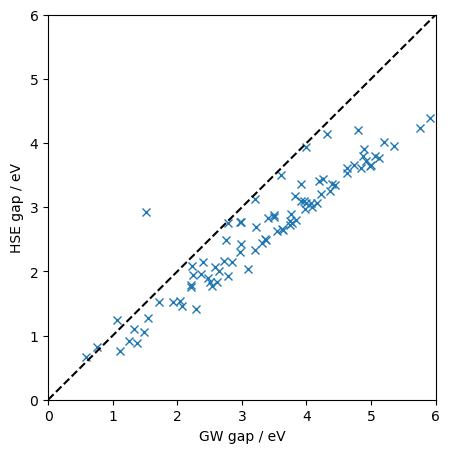

In [74]:
plt.figure(figsize=(5,5))
plt.plot(gaps_array[:,0],gaps_array[:,1],'x')
plt.xlim(0,6)
plt.ylim(0,6)
plt.plot([0,6],[0,6],'--k')
plt.xlabel('GW gap / eV')
plt.ylabel('HSE gap / eV')

In [75]:
offsets = []
for mat in overlap(all_ids,snum_ids):
    if 'Offset' in yu_gaps_etc[mat]:
        offsets.append([yu_gaps_etc[mat]['Offset'],snum_master[mat]["HSE_offset"]])
offsets_array = np.array(offsets)

In [76]:
offsets_1 = []
offsets_2 = []
offsets_3 = []
offsets_4 = []
for mat in overlap(all_ids,snum_ids):
    if 'Offset' in yu_gaps_etc[mat]:
        if yu_gaps_etc[mat]['Type'] == '1':
            offsets_1.append([yu_gaps_etc[mat]['Offset'],snum_master[mat]["HSE_offset"]])
        elif yu_gaps_etc[mat]['Type'] == '2':
            offsets_2.append([yu_gaps_etc[mat]['Offset'],snum_master[mat]["HSE_offset"]])
        elif yu_gaps_etc[mat]['Type'] == '3':
            offsets_3.append([yu_gaps_etc[mat]['Offset'],snum_master[mat]["HSE_offset"]])
        elif yu_gaps_etc[mat]['Type'] == '4':
            offsets_4.append([yu_gaps_etc[mat]['Offset'],snum_master[mat]["HSE_offset"]])
offsets_array_1 = np.array(offsets_1)
offsets_array_2 = np.array(offsets_2)
offsets_array_3 = np.array(offsets_3)
offsets_array_4 = np.array(offsets_4)

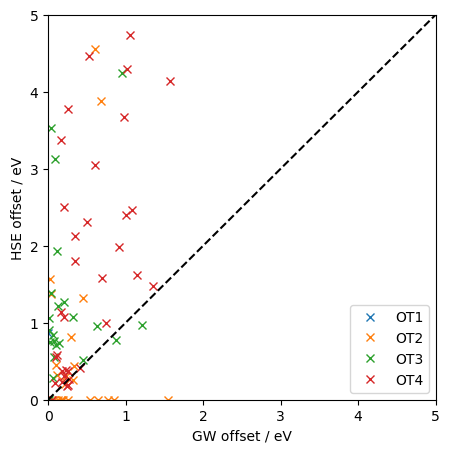

In [77]:
plt.figure(figsize=(5,5))
plt.plot(offsets_array_1[:,0],offsets_array_1[:,1],'x',label='OT1')
plt.plot(offsets_array_2[:,0],offsets_array_2[:,1],'x',label='OT2')
plt.plot(offsets_array_3[:,0],offsets_array_3[:,1],'x',label='OT3')
plt.plot(offsets_array_4[:,0],offsets_array_4[:,1],'x',label='OT4')
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0,6],[0,6],'--k')
plt.xlabel('GW offset / eV')
plt.ylabel('HSE offset / eV')
plt.legend()

Next thing to check would be to compare 'optical gaps' from Kim set to each set of Yu gaps or something? Like do they correspond more closely to df or da gaps? Specifically in OT2 and OT4 cases does it think optical = df

In [78]:
def MAE(a,b):
    return np.mean(np.abs(a-b))

In [79]:
MAE(offsets_array_1[:,0],offsets_array_1[:,1]),MAE(offsets_array_2[:,0],offsets_array_2[:,1]),MAE(offsets_array_3[:,0],offsets_array_3[:,1]),MAE(offsets_array_4[:,0],offsets_array_4[:,1])

(0.08667509999999998,
 0.7332939583333333,
 1.030751090909091,
 1.2329566176470592)

Text(0, 0.5, 'HSE offset / eV')

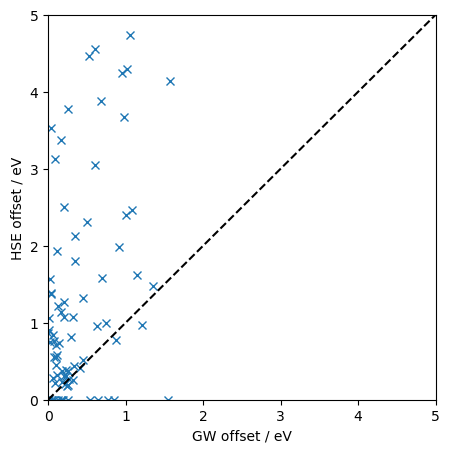

In [80]:
plt.figure(figsize=(5,5))
plt.plot(offsets_array[:,0],offsets_array[:,1],'x')
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0,6],[0,6],'--k')
plt.xlabel('GW offset / eV')
plt.ylabel('HSE offset / eV')

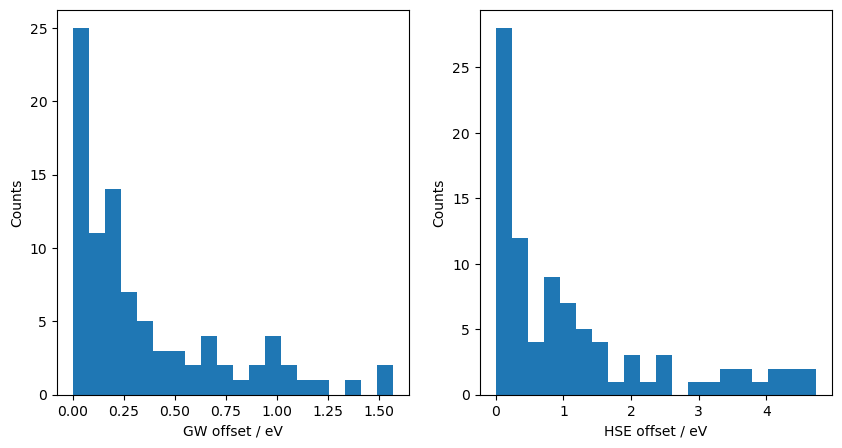

In [81]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(offsets_array[:,0],bins=20)
axs[0].set_xlabel('GW offset / eV')
axs[0].set_ylabel('Counts')
axs[1].hist(offsets_array[:,1],bins=20)
axs[1].set_xlabel('HSE offset / eV')
axs[1].set_ylabel('Counts')
plt.show()

In [82]:
twos_and_fours = [icsd for icsd in overlap(all_ids,snum_ids) if yu_gaps_etc[icsd]['Type'] in ['2','4']]

In [83]:
len(twos_and_fours)

58

In [84]:
yu_gaps_etc['100090']

{'Type': '3', 'E_g^da': 3.32, 'E_g': 3.25, 'Offset': 0.06999999999999984}

In [85]:
[yu_gaps_etc[id]['Type'] for id in twos_and_fours[:10]]

['4', '4', '2', '2', '4', '4', '4', '4', '4', '4']

In [86]:
check = twos_and_fours[2:6]

In [87]:
all_yu[all_yu.ICSD.isin(check)]

,Compound,ICSD,Space_group_no,E_g^i,E_g^df,E_g^da,Type,Dielectric_constant
42,K3GaO3,2269,12,–,5.35,5.53,2,2.36
52,Rb2In4O7,6321,162,3.77,3.81,4.03,4,3.15
113,Rb3BS3,411609,14,–,4.73,5.06,2,2.71
219,NaInTe2,25346,140,1.55,1.72,2.46,4,6.87


In [88]:
snum_check = [[icsd,snum_master[icsd]['HSE_gap'],snum_master[icsd]['HSE_opt']] for icsd in check]

In [89]:
snum_check #ICSD, HSE gap, HSE opt gap

[['2269', 3.952234, 3.952234],
 ['411609', 3.651901, 4.085866],
 ['6321', 2.760276, 6.533144],
 ['25346', 1.273205, 3.258834]]

In [90]:
waveder_path = "/home/matthew/PV_paper/OT2_4_examples/CsGaSe3/hse/optics/WAVEDER"
vasprun_path = "/home/matthew/PV_paper/OT2_4_examples/CsGaSe3/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path,threshold=0.1)

Lowest Energy Optical Transition:
Energy Difference: 3.0106 eV
Valence Band Energy: 0.9641 eV
Conduction Band Energy: 3.9747 eV
Matrix Element Magnitude: 1.2730e-01
K-point Index: 2
K-point Coordinates: [-0.         -0.          0.33333333]
Valence Band: 78
Conduction Band: 80
Direct gap? False
Band-gap from optics: 2.8154 eV
Direct gap from optics: 2.9147 eV
Band-gap from static: 2.8154 eV
Direct gap from static: 2.9146 eV


In [91]:
# Load vasprun.xml
vasprun_file = "/home/matthew/PV_paper/OT2_4_examples/CsGaSe3/hse/optics/vasprun.xml"
vasprun = Vasprun(vasprun_file,parse_potcar_file=False)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0.1

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")

Lowest dipole-allowed direct transition: 3.192 eV


Text(0, 0.5, '$\\varepsilon_2$')

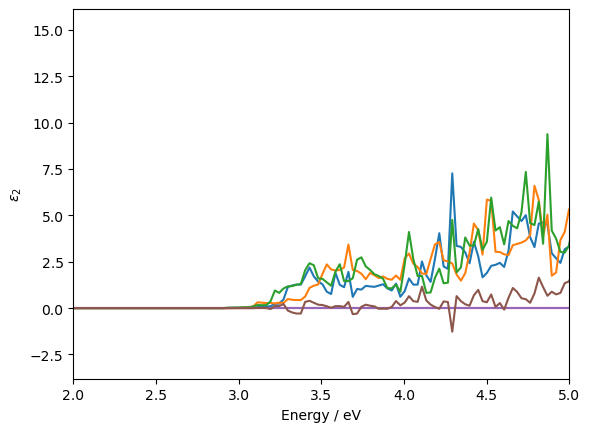

In [92]:
plt.plot(energies,eps_imag)
plt.xlim(2,5)
plt.xlabel('Energy / eV')
plt.ylabel(r'$\varepsilon_2$')

In [93]:
optics_path = "/home/matthew/PV_paper/OT2_4_examples/Cu5TlSe3/hse/optics/"
waveder_path = optics_path+"WAVEDER"
vasprun_path = optics_path+"vasprun.xml"
optical_transition = main(waveder_path, vasprun_path,threshold=0.1)

Lowest Energy Optical Transition:
Energy Difference: 0.4202 eV
Valence Band Energy: 5.5869 eV
Conduction Band Energy: 6.0071 eV
Matrix Element Magnitude: 7.6834e+00
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 167
Conduction Band: 172
Direct gap? True
Band-gap from optics: 0.21410000000000018 eV
Direct gap from optics: 0.21410000000000018 eV
Band-gap from static: 0.21410000000000018 eV
Direct gap from static: 0.21410000000000018 eV


In [94]:
# Load vasprun.xml
vasprun_file = "/home/matthew/PV_paper/OT2_4_examples/Cu5TlSe3/hse/optics/vasprun.xml"
vasprun = Vasprun(vasprun_file,parse_potcar_file=False)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")

Lowest dipole-allowed direct transition: 0.236 eV


In [95]:
waveder_path = "Cu2O/hse/optics/WAVEDER"
vasprun_path = "Cu2O/hse/optics/vasprun.xml"
optical_transition = main(waveder_path, vasprun_path,threshold=0.1)

Lowest Energy Optical Transition:
Energy Difference: 2.4810 eV
Valence Band Energy: 3.8647 eV
Conduction Band Energy: 6.3457 eV
Matrix Element Magnitude: 2.1210e-01
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 25
Conduction Band: 29
Direct gap? True
Band-gap from optics: 2.0667 eV
Direct gap from optics: 2.0667 eV
Band-gap from static: 2.0653 eV
Direct gap from static: 2.0664000000000002 eV


In [96]:
# Load vasprun.xml
vasprun_file = "Cu2O/hse/optics/vasprun.xml"
vasprun = Vasprun(vasprun_file,parse_potcar_file=False)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")

Lowest dipole-allowed direct transition: 2.104 eV


In [97]:
optics_path = "/home/matthew/PV_paper/OT2_4_examples/RbIn3S5/hse/optics/"
waveder_path = optics_path+"WAVEDER"
vasprun_path = optics_path+"vasprun.xml"
optical_transition = main(waveder_path, vasprun_path,threshold=0.1)

Lowest Energy Optical Transition:
Energy Difference: 2.2096 eV
Valence Band Energy: 3.1320 eV
Conduction Band Energy: 5.3416 eV
Matrix Element Magnitude: 3.3150e-01
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 115
Conduction Band: 117
Direct gap? True
Band-gap from optics: 2.1363999999999996 eV
Direct gap from optics: 2.1363999999999996 eV
Band-gap from static: 2.1365000000000003 eV
Direct gap from static: 2.1365000000000003 eV


In [98]:

vasprun = Vasprun(vasprun_path,parse_potcar_file=False)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")

Lowest dipole-allowed direct transition: 2.148 eV


In [99]:
optics_path = "/home/matthew/PV_paper/OT2_4_examples/Rb3AlO3/hse/optics/"
waveder_path = optics_path+"WAVEDER"
vasprun_path = optics_path+"vasprun.xml"
optical_transition = main(waveder_path, vasprun_path,threshold=0.1)

Lowest Energy Optical Transition:
Energy Difference: 4.5706 eV
Valence Band Energy: 0.0011 eV
Conduction Band Energy: 4.5717 eV
Matrix Element Magnitude: 2.9720e-01
K-point Index: 0
K-point Coordinates: [0. 0. 0.]
Valence Band: 90
Conduction Band: 96
Direct gap? True
Band-gap from optics: 4.3941 eV
Direct gap from optics: 4.3941 eV
Band-gap from static: 4.3941 eV
Direct gap from static: 4.3941 eV


In [100]:
vasprun = Vasprun(vasprun_path,parse_potcar_file=False)

# Extract dielectric function data
dielectric = vasprun.dielectric
energies = np.array(dielectric[0])  # Energy values in eV
eps_imag = np.array(dielectric[2])  # Imaginary part of dielectric function (xx, yy, zz components)

# Average over polarization directions
eps_imag_avg = np.mean(eps_imag, axis=1)

# Define a small threshold to filter out numerical noise
threshold = 0

# Find the first energy where eps_imag_avg exceeds the threshold
valid_indices = np.where(eps_imag_avg > threshold)[0]

if valid_indices.size > 0:
    first_allowed_transition = energies[valid_indices[0]]  # First dipole-allowed transition
    print(f"Lowest dipole-allowed direct transition: {first_allowed_transition:.3f} eV")
else:
    print("No significant dipole-allowed transitions found.")

Lowest dipole-allowed direct transition: 4.511 eV
